# Case study: Causal Discovery (time-series data)

Directory to store the downloaded causal chamber datasets.

In [1]:
DOWNLOAD_DIR = '/tmp'

In [2]:
import sys
sys.path = ['../'] + sys.path

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import numpy as np
import sempler
import sempler.plot
import scipy.stats

Did not load sempler.semi module and sempler.DRFNet class - optional dependencies are missing. See https://github.com/juangamella/sempler#installation for more details. All other functionality is available.
No module named 'rpy2'


### Plot settings

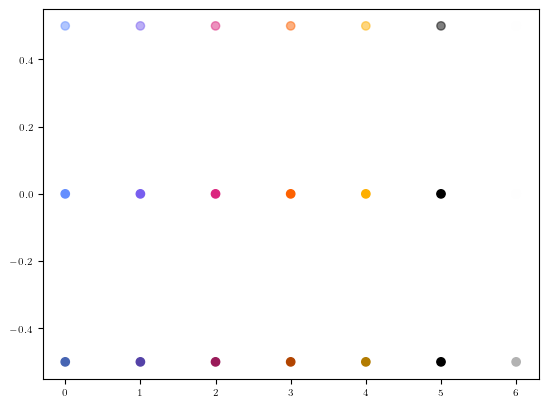

In [5]:
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

matplotlib.rcParams.update({'font.size': 7})
MM = 1/25.4 # inches to mm

def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

# Color palettes
color_blind_1 = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4', '#020202',]
color_blind_2 = ['#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac']
color_blind_3 = ['#8c510a', '#bf812d', '#dfc27d', '#f6e8c3', '#c7eae5', '#80cdc1', '#35978f', '#01665e']
ibm_color_blind = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000", "#000000", "#ffffff"]
rainbow10 = ["#ff4365", "#ffdd43", "#59ff43", "#43ffdd", "#7395ff", "#4365ff", "#e943ff", "#601e9e", "#6a6a6a", "#964b00"]


# Pick one and show

palette = ibm_color_blind

base = to_rgb(palette)
basea = to_rgb(palette, a=0.5)
baseb = to_rgb(palette, b=0.7)
plt.scatter(np.arange(len(base)), np.zeros(len(base)), c = base)
plt.scatter(np.arange(len(base)), np.ones(len(base))*0.5, c = basea)
plt.scatter(np.arange(len(base)), np.ones(len(base))*-0.5, c = baseb)

## Define metrics for ground-truth effect recovery

Precision: $\frac{TP}{TP+FP}\quad\quad$ Recall: $\frac{TP}{P}$

In [6]:
def precision(estimate, truth):
    # TP = edges in estimate that are also in truth
    # FP + TP = total edges in estimate    
    return np.logical_and(estimate,truth).sum() / estimate.sum()

def recall(estimate, truth):
    # TP = edges in estimate that are also in truth
    # P = total edges in truth
    return np.logical_and(estimate,truth).sum() / truth.sum()

### Define the ground truth graph

For the standard configuration of the wind tunnel we can simply take the subgraph induced by the variables we use (this may not be the case for other configurations)

In [7]:
import causalchamber
from causalchamber.ground_truth import latex_name
from causalchamber.utils import graph_to_tikz


Fetching list of available datasets from https://causalchamber.s3.eu-central-1.amazonaws.com/downloadables/directory.yaml ... done.
If you use our datasets or models for your work please consider citing:

@article{gamella2024chamber,
  title={The Causal Chambers: Real Physical Systems as a Testbed for AI Methodology},
  author={Gamella, Juan L. and B"uhlmann, Peter and Peters, Jonas},
  journal={arXiv preprint arXiv:2404.11341},
  year={2024}
}



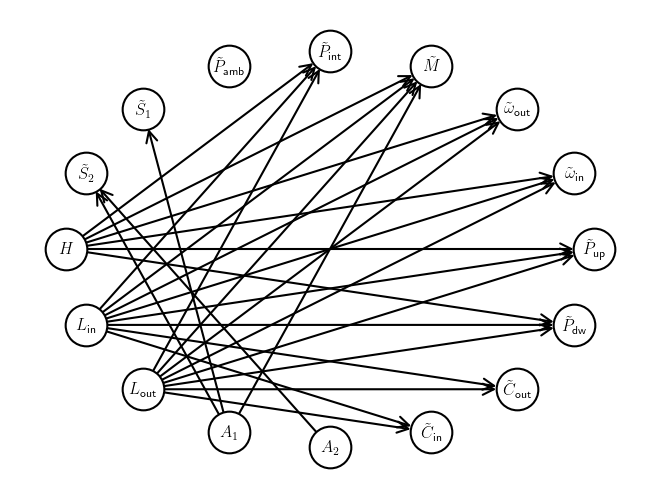

    \begin{tikzpicture}
        \node[circle, inner sep=0.12em] (0) at (-0.765, 1.848) {$H$};
        \node[circle, inner sep=0.12em] (1) at (-1.414, 1.414) {$L_\text{in}$};
        \node[circle, inner sep=0.12em] (2) at (-1.848, 0.765) {$L_\text{out}$};
        \node[circle, inner sep=0.12em] (3) at (-2.000, -0.000) {$A_1$};
        \node[circle, inner sep=0.12em] (4) at (-1.848, -0.765) {$A_2$};
        \node[circle, inner sep=0.12em] (5) at (-1.414, -1.414) {$\tilde{C}_\text{in}$};
        \node[circle, inner sep=0.12em] (6) at (-0.765, -1.848) {$\tilde{C}_\text{out}$};
        \node[circle, inner sep=0.12em] (7) at (0.000, -2.000) {$\tilde{P}_\text{dw}$};
        \node[circle, inner sep=0.12em] (8) at (0.765, -1.848) {$\tilde{P}_\text{up}$};
        \node[circle, inner sep=0.12em] (9) at (1.414, -1.414) {$\tilde{\omega}_\text{in}$};
        \node[circle, inner sep=0.12em] (10) at (1.848, -0.765) {$\tilde{\omega}_\text{out}$};
        \node[circle, inner sep=0.12em] (11) at (2.000, 

In [8]:
variables = ['hatch', 'load_in', 'load_out', 'pot_1', 'pot_2', 'current_in', 'current_out', 'pressure_downwind', 'pressure_upwind', 'rpm_in', 'rpm_out',
       'mic', 'pressure_intake', 'pressure_ambient', 'signal_1', 'signal_2']
true_dag = causalchamber.ground_truth.graph('wt', 'standard').loc[variables, variables].values
latex_names = [latex_name(v) for v in variables]
sempler.plot.plot_graph(true_dag, labels=latex_names)
print(graph_to_tikz(true_dag, radius=2, labels=latex_names))

## Load, process and visualize dataset

In [9]:
dataset = causalchamber.datasets.Dataset(name="wt_walks_v1", root=DOWNLOAD_DIR)
dataset.available_experiments()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46.5M/46.5M [00:01<00:00, 31.8MiB/s]


  Verifying checksum... done.
  Extracting zip-file contents to "/tmp"... done.


['loads_hatch_mix_slow_run_1',
 'loads_hatch_mix_fast_run_3',
 'actuators_random_walk_1',
 'loads_hatch_mix_slow_run_2',
 'regime_jumps_single',
 'loads_hatch_mix_fast_run_1',
 'regime_jumps_multi',
 'actuators_random_walk_2',
 'actuators_random_walk_13',
 'loads_hatch_mix_fast_run_2',
 'actuators_random_walk_14',
 'actuators_random_walk_12',
 'loads_hatch_mix_slow_run_5',
 'actuators_random_walk_5',
 'actuators_random_walk_7',
 'actuators_random_walk_15',
 'loads_hatch_mix_fast_run_5',
 'loads_hatch_mix_slow_run_3',
 'actuators_random_walk_9',
 'actuators_random_walk_8',
 'actuators_random_walk_10',
 'actuators_random_walk_4',
 'actuators_random_walk_16',
 'actuators_random_walk_6',
 'actuators_random_walk_11',
 'loads_hatch_mix_slow_run_4',
 'actuators_random_walk_3',
 'loads_hatch_mix_fast_run_4']

In [10]:
df = dataset.get_experiment('actuators_random_walk_1').as_pandas_dataframe()
df_norm = df[variables]
df_norm -= df_norm.min()
df_norm /= df_norm.max()

## Run PCMCI+

In [11]:
import tigramite.pcmci
from tigramite.independence_tests.parcorr import ParCorr
from tigramite import data_processing as pp
#from tigramite.independence_tests.robust_parcorr import RobustParCorr
#from tigramite.independence_tests.parcorr_wls import ParCorrWLS
from tigramite import plotting as tp

In [12]:
dataframe = pp.DataFrame(df_norm.values, 
                         datatime = {0:np.arange(len(df_norm))}, 
                         var_names=df_norm.columns)
pcmci = tigramite.pcmci.PCMCI(
    dataframe=dataframe, 
    cond_ind_test=ParCorr(),
    verbosity=1)

In [13]:
%%time
tau_max = 10
pc_alpha = 1e-2
np.random.seed(13)
results = pcmci.run_pcmciplus(tau_max=tau_max, 
                              pc_alpha=pc_alpha,                              
                             )


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 10
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable hatch has 2 link(s):
        (hatch -1): max_pval = 0.00000, |min_val| =  0.709
        (signal_2 -6): max_pval = 0.00724, |min_val| =  0.085

    Variable load_in has 5 link(s):
        (load_in -1): max_pval = 0.00000, |min_val| =  0.700
        (load_in -4): max_pval = 0.00068, |min_val| =  0.107
        (load_in -6): max_pval = 0.00074, |min_val| =  0.107
        (load_in -5): max_pval = 0.00400, |min_val| =  0.091
        (rpm_in -10): max_pval = 0.00980, |min_val| =  0.082

    Variable load_out has 2 link(s):
        (load_out -1): max_pval = 0.00000, |min_val| =  0.724
        (load_out -3): max_pval = 0.00092, |min_val| =  0.105

    Variable pot_1 has 1 link(s):
        (pot_1 -1): max_pval = 0.00000, |min_val| =  0.707

    Variabl

### Visualize results

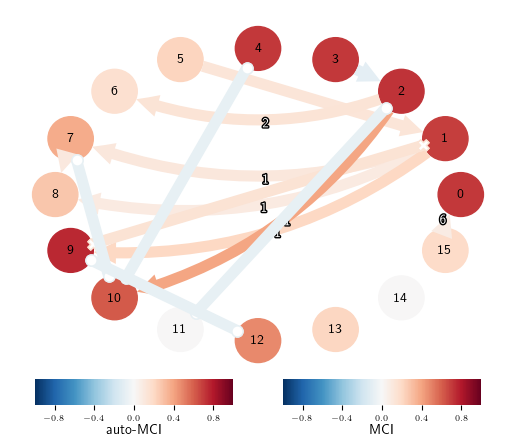

In [14]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    ); plt.show()

#### Contemporaneous CPDAG

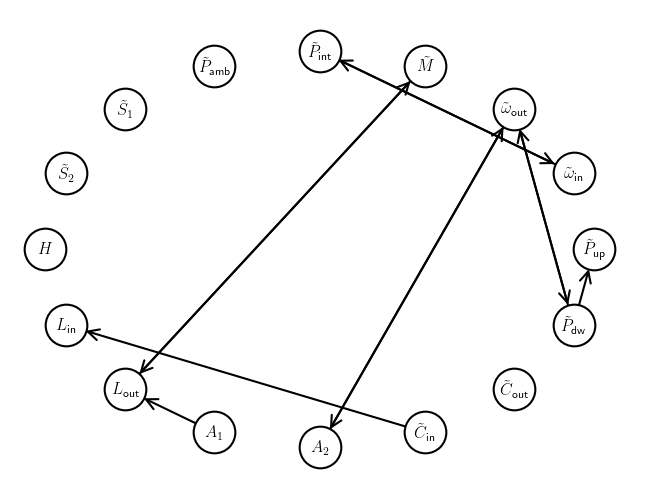

    \begin{tikzpicture}
        \node[circle, inner sep=0.12em] (0) at (-0.765, 1.848) {$H$};
        \node[circle, inner sep=0.12em] (1) at (-1.414, 1.414) {$L_\text{in}$};
        \node[circle, inner sep=0.12em] (2) at (-1.848, 0.765) {$L_\text{out}$};
        \node[circle, inner sep=0.12em] (3) at (-2.000, -0.000) {$A_1$};
        \node[circle, inner sep=0.12em] (4) at (-1.848, -0.765) {$A_2$};
        \node[circle, inner sep=0.12em] (5) at (-1.414, -1.414) {$\tilde{C}_\text{in}$};
        \node[circle, inner sep=0.12em] (6) at (-0.765, -1.848) {$\tilde{C}_\text{out}$};
        \node[circle, inner sep=0.12em] (7) at (0.000, -2.000) {$\tilde{P}_\text{dw}$};
        \node[circle, inner sep=0.12em] (8) at (0.765, -1.848) {$\tilde{P}_\text{up}$};
        \node[circle, inner sep=0.12em] (9) at (1.414, -1.414) {$\tilde{\omega}_\text{in}$};
        \node[circle, inner sep=0.12em] (10) at (1.848, -0.765) {$\tilde{\omega}_\text{out}$};
        \node[circle, inner sep=0.12em] (11) at (2.000, 

In [15]:
A_inst = np.logical_or(results['graph'][:,:,0] == "-->",
                       results['graph'][:,:,0].T == "<--")
A_inst_undir = results['graph'][:,:,0] == "o-o"
inst_cpdag = np.logical_or(A_inst, A_inst_undir)
sempler.plot.plot_graph(inst_cpdag, labels=latex_names)
print(graph_to_tikz(inst_cpdag, radius=2, labels=latex_names))

#### Lagged effects DAG

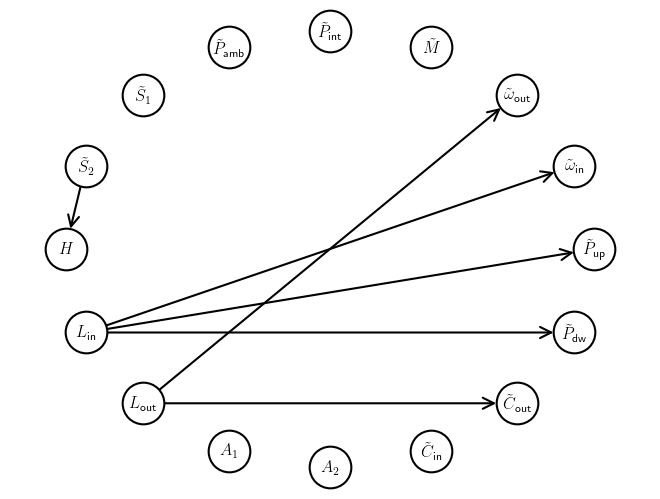

    \begin{tikzpicture}
        \node[circle, inner sep=0.12em] (0) at (-0.765, 1.848) {$H$};
        \node[circle, inner sep=0.12em] (1) at (-1.414, 1.414) {$L_\text{in}$};
        \node[circle, inner sep=0.12em] (2) at (-1.848, 0.765) {$L_\text{out}$};
        \node[circle, inner sep=0.12em] (3) at (-2.000, -0.000) {$A_1$};
        \node[circle, inner sep=0.12em] (4) at (-1.848, -0.765) {$A_2$};
        \node[circle, inner sep=0.12em] (5) at (-1.414, -1.414) {$\tilde{C}_\text{in}$};
        \node[circle, inner sep=0.12em] (6) at (-0.765, -1.848) {$\tilde{C}_\text{out}$};
        \node[circle, inner sep=0.12em] (7) at (0.000, -2.000) {$\tilde{P}_\text{dw}$};
        \node[circle, inner sep=0.12em] (8) at (0.765, -1.848) {$\tilde{P}_\text{up}$};
        \node[circle, inner sep=0.12em] (9) at (1.414, -1.414) {$\tilde{\omega}_\text{in}$};
        \node[circle, inner sep=0.12em] (10) at (1.848, -0.765) {$\tilde{\omega}_\text{out}$};
        \node[circle, inner sep=0.12em] (11) at (2.000, 

In [16]:
lagged_dag = np.logical_or((results['graph'][:,:,1:] == "-->").any(axis=2),
                          (results['graph'][:,:,1:] == "<--").any(axis=2))
# Remove self edges
np.fill_diagonal(lagged_dag, False)
sempler.plot.plot_graph(lagged_dag, labels=latex_names)
lagged_dag
print(graph_to_tikz(lagged_dag, radius=2, labels=latex_names))

### Compute metrics

In [17]:
inst_dags = sempler.utils.all_dags(inst_cpdag)
metrics = np.zeros((len(inst_dags),2))
for i,dag in enumerate(inst_dags):
    A = np.logical_or(dag,lagged_dag)
    metrics[i,0] = precision(A, true_dag)
    metrics[i,1] = recall(A, true_dag)
    print("DAG",i)
    print("  precision:",metrics[i,0])
    print("  recall:",metrics[i,1])

DAG 0
  precision: 0.46153846153846156
  recall: 0.23076923076923078
DAG 1
  precision: 0.46153846153846156
  recall: 0.23076923076923078
DAG 2
  precision: 0.46153846153846156
  recall: 0.23076923076923078
DAG 3
  precision: 0.46153846153846156
  recall: 0.23076923076923078
DAG 4
  precision: 0.46153846153846156
  recall: 0.23076923076923078
DAG 5
  precision: 0.46153846153846156
  recall: 0.23076923076923078
